# Information Retrieval Exercise 2 Notebook

This is the template notebook for Exercise 2. The specification for the exercise and the corresponding Exercise 2 Quiz submission instance are available on the Moodle page of the course.

## Assumed Knowledge

This Exercise assumes knowedge of Pandas and PyTerrier from Exercise 1. The relevant parts of the PyTerrier documentation are:
 - [Using Terrier indices in PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)
 - [Terrier Retrieval using PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html), e.g. BatchRetrieve
 - [Operators on PyTerrier transformers](https://pyterrier.readthedocs.io/en/latest/operators.html)


## Setup

NB: Windows users may need to use `!pip install  --user python-terrier gensim` -- you can ignore warnings about cython, PATH etc. If in doubt, resort to Colab.

In [1]:
# !pip install python-terrier gensim

In [2]:
import pyterrier as pt
if not pt.started():
    pt.init()

import pandas as pd
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 200)

/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


PyTerrier 0.6.0 has loaded Terrier 5.5 (built by craigmacdonald on 2021-05-20 13:12)


# Datasets for Ex2

For Exercise 2, we'll be using the Datasets API to obtain the files we need for this exercise. PyTerrier actually provides many datasets. You can list all of them using `pt.list_datasets()`.

In [3]:
pt.list_datasets()

,dataset,topics,topics_lang,qrels,corpus,corpus_lang,index,info_url
0,50pct,"[training, validation]",en,"[training, validation]",None,None,"[ex1, ex2]",None
1,antique,"[train, test]",en,"[train, test]",True,en,None,https://ciir.cs.umass.edu/downloads/Antique/readme.txt
2,vaswani,True,en,True,True,en,True,http://ir.dcs.gla.ac.uk/resources/test_collections/npl/
3,trec-deep-learning-docs,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,None,https://microsoft.github.io/msmarco/
4,trec-deep-learning-passages,"[train, dev, dev.small, eval, eval.small, test-2019, test-2020]",en,"[train, dev, test-2019, test-2020, dev.small]",True,en,None,https://microsoft.github.io/MSMARCO-Passage-Ranking/
...,...,...,...,...,...,...,...,...
289,irds:wikir/en1k/validation,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en1k/validation
290,irds:wikir/en59k,None,None,None,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k
291,irds:wikir/en59k/test,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k/test
292,irds:wikir/en59k/training,True,en,True,True,en,None,https://ir-datasets.com/wikir.html#wikir/en59k/training


There are several sets of files we need for Exercise 2:
 - the index for 50% of the TREC GOV corpus. We provide this through the "50pct" dataset, but you will need the username and password that we will assign to you once you sign the user license agreement.
 - the topics (queries) and qrels (relevance assessments) for evaluating the performance of our search engine. These come from the "trec-wt-2004" dataset.

Update your username and password. DO NOT SHARE your login details with other students - all they need to do is submit a signed user agreement to us.



In [4]:
def _filter_on_qid_type(self, component, variant):
  import pandas as pd
  if component == "topics":
    data = self.get_topics("all")
  elif component == "qrels":
    data = self.get_qrels("all")
  qid2type = pd.read_csv("http://mirror.ir-datasets.com/79737768b3be1aa07b14691aa54802c5", names=["qid", "type"], sep=" ")
  qid2type["qid"] = qid2type.apply(lambda row: row["qid"].split("-")[1], axis=1)
  rtr = data.merge(qid2type[qid2type["type"] == variant], on=["qid"])
  if len(rtr) == 0:
    raise ValueError("No such topic type '%s'" % variant)
  rtr.drop(columns=['type'], inplace=True)
  return (rtr, "direct")
dataset = pt.get_dataset("trec-wt-2004")
for t in ["np", "td", "hp"]:
  dataset.locations["qrels"][t] = _filter_on_qid_type
  dataset.locations["topics"][t] = _filter_on_qid_type
dataset.locations["qrels"]["all"] = ('04.qrels.web.mixed.txt', "http://www.dcs.gla.ac.uk/~craigm/04.qrels.web.mixed.txt")
dataset.locations["topics_prefixed"]["all"] = ('Web2004.query.stream.trecformat.txt', "http://www.dcs.gla.ac.uk/~craigm/Web2004.query.stream.trecformat.txt", "trec")

In [5]:
USERNAME = "2597630w"
PASSWORD = "0729af3d"

dotgov_50pct = pt.get_dataset("50pct", user=USERNAME, password=PASSWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

The size of the "50pct" index is 800MB - this will take a minute or so for Colab to download before we load it for the first time.

In [6]:
indexref = dotgov_50pct.get_index()
index = pt.IndexFactory.of(indexref)

# Q1

Using this setup, you now have sufficient knowledge from the introductory lab to complete Q1 of this assessed exercise, namely to get the indexing statistics of the "50pct" collection.

In [7]:
#YOUR SOLUTION
print(index.getCollectionStatistics())

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 0
Number of tokens: 572916194
Field names: []
Positions:   false



# Retrieval & Evaluation

In our experiments, we are using three sets of topics: "hp", "np" and "td". We can obtain them from the `dotgov_topicsqrels` dataset as follows:

In [8]:
topics = dotgov_topicsqrels.get_topics(variant="hp")
topics.head(5)

,qid,query
0,6,philadelphia streets
1,7,togo embassy
2,9,baltimore
3,17,secure linux
4,29,grand canyon monitoring and research center


Let's create a simple TF_IDF retriever - we will use this for demonstrating IR evaluation using PyTerrier.

In [9]:
retr = pt.BatchRetrieve(index, wmodel="TF_IDF")

Let's see how we can actually evaluate our TF_IDF retrieval system. Firstly, we'll need the qrels.

In [10]:
qrels = dotgov_topicsqrels.get_qrels(variant='hp')
qrels.head()

,qid,docno,label
0,6,G00-02-2698369,0
1,6,G00-05-1954873,0
2,6,G00-05-2082516,0
3,6,G00-05-3598626,0
4,6,G00-09-3229156,0


We can use `pt.Utils.evaluate(results, qrels)` to evaluate the results    
Args:    
 - metrics, `default = ["map", ndcg"]`, select the evaluation metrics    
 - perquery, `default = False`, select whether to show the mean of the metrics over all queries or the metrics for each query

In [11]:
res = retr.transform(topics)
eval = pt.Utils.evaluate(res, qrels, metrics=["map"])
eval

{'map': 0.20894845478512017}

However, creating the res dataframe for each system in turn, and then evaluating it is laborious. We strongly recommend using [`pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to evaluate one or more retrieval systems at once, in a declarative manner. 

Take the time to read the [documentation for `pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to understand its available functionality. Q2-Q4 will all require that you adapt the arguments to `pt.Experiment()` and use its output in different ways (e.g. for significance testing).

In [12]:
pt.Experiment(
    [retr],
     dotgov_topicsqrels.get_topics(variant='hp'),
     dotgov_topicsqrels.get_qrels(variant='hp'), 
     eval_metrics=['map']
)

,name,map
0,BR(TF_IDF),0.208948


# Q2(a)

You now have enough information to complete Q2(a) of the assessed exercise. 

*Hint*: We encourage you to write your own functions that perform reusable operations across different topic sets.

In [14]:
#YOUR SOLUTION
# wmodel: a list of transformers to be evaluated
# topic: topic sets, 'hp', 'np', 'td'
def evaluate(wmodel, topic, measure):
    return pt.Experiment(wmodel, dotgov_topicsqrels.get_topics(variant=topic),
                         dotgov_topicsqrels.get_qrels(variant=topic),
                         eval_metrics=measure, round=4, baseline=0)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
hp_df = evaluate([tfidf, bm25, pl2], 'hp', ['map'])
np_df = evaluate([tfidf, bm25, pl2], 'np', ['map'])
td_df = evaluate([tfidf, bm25, pl2], 'td', ['map'])
hp_df

,name,map,map +,map -,map p-value
0,BR(TF_IDF),0.2089,NaN,NaN,NaN
1,BR(BM25),0.2186,11.0,20.0,0.463462
2,BR(PL2),0.2251,17.0,36.0,0.448418


In [15]:
np_df

,name,map,map +,map -,map p-value
0,BR(TF_IDF),0.4477,NaN,NaN,NaN
1,BR(BM25),0.4416,6.0,11.0,0.066561
2,BR(PL2),0.4392,17.0,20.0,0.654736


In [16]:
td_df

,name,map,map +,map -,map p-value
0,BR(TF_IDF),0.0698,NaN,NaN,NaN
1,BR(BM25),0.0703,26.0,31.0,0.249291
2,BR(PL2),0.0695,39.0,36.0,0.862098


# Q2(b) 

Question 2(b) is concerned with drawing interpolated recall precision graphs, each comparing TFIDF, BM25 and PL2, allowing you to answer the corresponding quiz questions. You will need to use the `"iprec_at_recall"` measure. You should have three curves, respectively addressing the "hp", "np", and "td" topic sets.

*Hint*: Matplotlib has a [`savefig()`](https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/#the-savefig-method) function for saving a PNG of a figure.

In [17]:
#YOUR SOLUTION
import matplotlib.pyplot as plt
plt.style.use('seaborn')

x = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def evaluate(wmodel, topic, measure):
    return pt.Experiment(wmodel, dotgov_topicsqrels.get_topics(variant=topic),
                         dotgov_topicsqrels.get_qrels(variant=topic),
                         eval_metrics=measure, round=4)
hp_curve = evaluate([tfidf, bm25, pl2], 'hp', ['iprec_at_recall'])
np_curve = evaluate([tfidf, bm25, pl2], 'np', ['iprec_at_recall'])
td_curve = evaluate([tfidf, bm25, pl2], 'td', ['iprec_at_recall'])

In [38]:
td_curve

,name,IPrec@0.0,IPrec@0.1,IPrec@0.2,IPrec@0.3,IPrec@0.4,IPrec@0.5,IPrec@0.6,IPrec@0.7,IPrec@0.8,IPrec@0.9,IPrec@1.0
0,BR(TF_IDF),0.2761,0.1759,0.1282,0.1017,0.0864,0.0573,0.0415,0.0248,0.0125,0.0068,0.0056
1,BR(BM25),0.2746,0.1765,0.1284,0.1035,0.0873,0.0583,0.0421,0.0251,0.0123,0.0067,0.0056
2,BR(PL2),0.2708,0.1644,0.1247,0.1063,0.0877,0.0583,0.0434,0.0279,0.0126,0.0066,0.0056


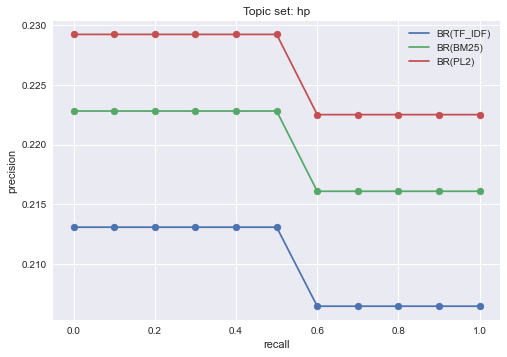

In [18]:
def plot_curve(curve, title):
    for i in range(3):
        plt.plot(x, curve.iloc[i][1:], label=curve.iloc[i][0])
        plt.scatter(x, curve.iloc[i][1:])
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.legend()
    plt.title(title)
    plt.savefig('%s.png' % title)
plot_curve(hp_curve, 'Topic set: hp')

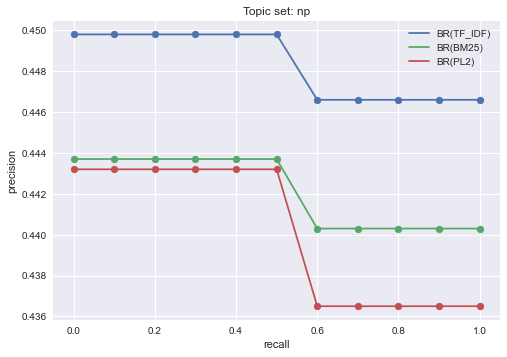

In [19]:
plot_curve(np_curve, 'Topic set: np')

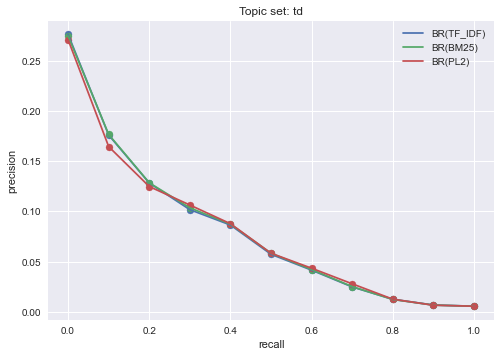

In [20]:
plot_curve(td_curve, 'Topic set: td')

# Q2(c)

Now identify the most effective weighting model in terms of average MAP across the 3 topic sets.

In [21]:
#YOUR SOLUTION
# highest = PL2
avg_map = []
for i in range(3):
    avg_map.append(((hp_df.iloc[i]['map'] + np_df.iloc[i]['map'] 
                     + td_df.iloc[i]['map']) / 3, hp_df.iloc[i]['name']))
avg_map

[(0.2421333333333333, 'BR(TF_IDF)'),
 (0.24350000000000002, 'BR(BM25)'),
 (0.2446, 'BR(PL2)')]

# Q3 Query Expansion

Query expansion is one of the most well-known and effective techniques for improving the effectiveness of a search engine. We'll be using Terrier's Bo1 query expansion model.

See the [relevant documentation](https://pyterrier.readthedocs.io/en/latest/rewrite.html#bo1queryexpansion) about creating a QE transformer pipeline in PyTerrier using the Bo1 model.

You now have enough information to conduct Q3(a) and (b).



## Q3(a)
Run the required experiments for evaluating the application of query expansion on the best weighting model identified in the previous question.

In [22]:
#YOUR SOLUTION
# using PL2
bo1 = pt.rewrite.Bo1QueryExpansion(index)
pipe_QE = pl2 >> bo1 >> pl2
pt.Experiment([pl2, pipe_QE],
              dotgov_topicsqrels.get_topics(variant='hp'),
              dotgov_topicsqrels.get_qrels(variant='hp'),
              eval_metrics=['map'], round=4, baseline=0,
              names=["PL2", "QE"])

,name,map,map +,map -,map p-value
0,PL2,0.2251,NaN,NaN,NaN
1,QE,0.2423,21.0,29.0,0.252385


In [23]:
pt.Experiment([pl2, pipe_QE],
              dotgov_topicsqrels.get_topics(variant='np'),
              dotgov_topicsqrels.get_qrels(variant='np'),
              eval_metrics=['map'], round=4, baseline=0,
              names=["PL2", "QE"])

,name,map,map +,map -,map p-value
0,PL2,0.4392,NaN,NaN,NaN
1,QE,0.4442,18.0,18.0,0.847885


In [24]:
pt.Experiment([pl2, pipe_QE],
              dotgov_topicsqrels.get_topics(variant='td'),
              dotgov_topicsqrels.get_qrels(variant='td'),
              eval_metrics=['map'], round=4, baseline=0,
              names=["PL2", "QE"])

,name,map,map +,map -,map p-value
0,PL2,0.0695,NaN,NaN,NaN
1,QE,0.0671,30.0,45.0,0.239678


## Q3(b)

This question calls for a query-delta bar chart (See example in Lecture 5). You will need to use the ` perquery=True` option for `pt.Experiment()`. 

*Hints*: 
 - You may need a [self-join](https://www.w3schools.com/sql/sql_join_self.asp) on a dataframe.
 - You can iterate through a dataframe using [`dataframe.iterrows()`](https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/)

In [25]:
#YOUR SOLUTION
# using BM25
pipe_QE = bm25 >> bo1 >> bm25
delta_ap_df = pt.Experiment([bm25, pipe_QE],
                              dotgov_topicsqrels.get_topics(variant='td'),
                              dotgov_topicsqrels.get_qrels(variant='td'),
                              eval_metrics=['map'], round=4,
                              names=["BM25", "QE"], perquery=True)

In [48]:
bo1_td = pipe_QE.transform(dotgov_topicsqrels.get_topics(variant='td'))
bo1_td[bo1_td['qid'] == '74']['query'].unique()

array(['applypipeline:off skin^1.402936462 cancer^1.233351080 sunscreen^0.081970932 cell^0.071433646 melanoma^0.070226770 sun^0.068207895 squamou^0.067213993 carcinoma^0.063889040 uv^0.055406079 basal^0.054696254'],
      dtype=object)

In [42]:
import numpy as np

def plot_delta(delta_ap_df):
    ap_plot_df = delta_ap_df.copy().iloc[:75]
    ap_plot_df['delta'] = np.array(delta_ap_df.iloc[75:]['value'].tolist()) - np.array(delta_ap_df.iloc[:75]['value'].tolist())
    topics = dotgov_topicsqrels.get_topics(variant='td')
    ap_plot_df = pd.merge(ap_plot_df, topics, on='qid', how='left')
    plot_df = ap_plot_df[ap_plot_df['delta'].apply(np.abs) > 0.02].sort_values(by='delta', ascending=False)
    x = plot_df['qid'] + ': ' + plot_df['query']
    y = plot_df['delta']
    plt.bar(x, y)
    plt.xlabel("Qid: Query")
    plt.ylabel("Delta AP")
    plt.xticks(rotation='vertical')
    plt.show()
    return plot_df

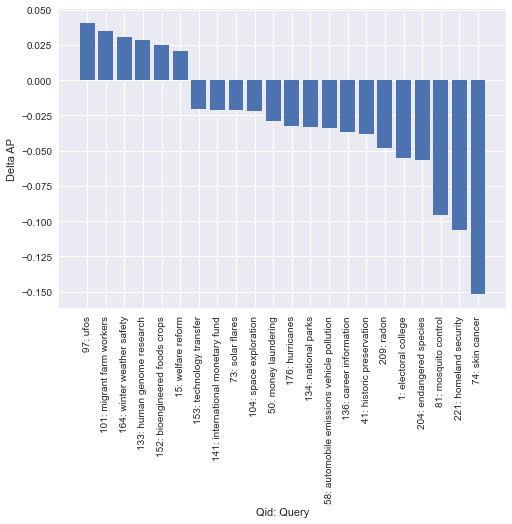

,name,qid,measure,value,delta,query
31,BM25,97,map,0.2206,0.0409,ufos
33,BM25,101,map,0.1072,0.0348,migrant farm workers
56,BM25,164,map,0.2263,0.0303,winter weather safety
43,BM25,133,map,0.0318,0.0287,human genome research
50,BM25,152,map,0.0505,0.0253,bioengineered foods crops
5,BM25,15,map,0.1919,0.0209,welfare reform
51,BM25,153,map,0.0869,-0.0203,technology transfer
48,BM25,141,map,0.1244,-0.0208,international monetary fund
25,BM25,73,map,0.0302,-0.0212,solar flares
36,BM25,104,map,0.0280,-0.0216,space exploration


In [43]:
plot_delta(delta_ap_df)

# Q4 Word Embeddings

Q4 asks for a word2vec-based query expansion model. Word2vec (also called word embeddings) is a shallow neural network where semantically similar words end up with similar embedding vectors.

If you haven't taken Text-as-Data, you can do some background reading about word embeddings at:
 - https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
 - https://en.wikipedia.org/wiki/Word2vec
 - https://en.wikipedia.org/wiki/Word_embedding

In general, while word2vec is still a very widely used model, note that it has been surpassed by more complex models such as BERT. But word2vec is still useful to consider in the context of query expansion.


In this part of the exercise, we will use [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), a Python toolkit for working with a word2vec model. 

We are providing a pre-trained word2vec model that Gensim will download and open - the file is very large, so this might take a few minutes to download and a couple of minutes to load. You can read on while it opens.

In [28]:
import gensim.downloader as api
%time model = api.load("glove-wiki-gigaword-300")

/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


CPU times: user 1min 42s, sys: 1.57 s, total: 1min 43s
Wall time: 1min 46s


`model` is of type [gensim.models.keyedvectors.KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors).

You can think of this as a dictionary mapping string words to the vector embeddings for each word.  For example, we can get the vector for the word `'government'` as follows:

In [29]:
emb = model.get_vector("government")
print(emb.shape)
print(emb)

(300,)
[ 2.5470e-02 -1.0216e-01 -2.8455e-01  2.8603e-01  1.9018e-01 -4.7529e-01
  1.4468e-01  1.9805e-01 -4.2931e-02 -2.9325e+00 -6.3137e-01  9.7630e-02
  1.0803e-01  5.4072e-01 -1.1834e-02  6.8399e-01  3.7241e-02 -3.8651e-01
  5.1331e-01 -4.0682e-01  3.3802e-01  3.9780e-02  1.0934e+00 -2.6993e-02
 -3.2652e-01  1.8426e-01  2.5084e-02 -1.9201e-02 -1.9761e-01  4.9951e-01
 -2.3426e-01 -1.1926e-01  4.3991e-02  3.2443e-01 -2.6306e-01 -1.7991e-01
  2.3484e-01  3.4124e-01 -3.1304e-01 -1.9777e-01 -1.9651e-01  2.8835e-01
 -1.6815e-01  3.8187e-01 -1.6562e-01 -4.0849e-01 -3.9998e-01  2.6185e-01
 -5.3972e-01  2.4353e-01  1.3366e-01 -3.0213e-01  3.7712e-01  1.8414e-01
  7.4082e-03  1.4511e-01  3.2574e-01  1.6853e-01 -1.0872e-01  1.9417e-02
 -3.2784e-01  3.9864e-01 -7.8588e-01  2.3249e-01  2.8092e-02 -4.3737e-01
  1.3954e-01 -4.0254e-01 -3.2712e-01  4.1180e-01  1.3976e-01  6.8819e-01
  3.9624e-02  2.7002e-02  2.3729e-01 -6.6964e-02  5.5686e-02  2.4415e-01
  1.2575e-03  5.1176e-01  1.3287e-01 -3.3563

As you can see, each word is represented by a 300-dimension vector.

We can also ask `model` for the most similar words to `'government'` using [`model.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). It returns the 10 most similar words, based on the cosine similarity of their emebddings to that of `'government'`. 

See also: [Example in Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#what-can-i-do-with-word-vectors).

In [62]:
model.most_similar(['natural', 'language', 'processing'])

[('example', 0.5769190788269043),
 ('languages', 0.5604609251022339),
 ('processes', 0.5535740256309509),
 ('instance', 0.5427410006523132),
 ('e.g.', 0.5152060985565186),
 ('learning', 0.5118433833122253),
 ('means', 0.5095254182815552),
 ('forms', 0.5081191658973694),
 ('particular', 0.5075994729995728),
 ('use', 0.504721999168396)]

As you can see, some words are clearly related to the original word `'government'`, including some lexical variations (`'governments'`), as well as semantically similar (`"authorities"`) words. You can also see some words that perhaps seem unrelated - probably they are highly weighted because they appeared in similar contexts to `"government"` (e.g. `"saying"`).

# Q4 Word2Vec-based Query Expansion

The next task is to use `model` to develop your custom transformer for a word2vec-based query expansion.

*Hints*:
 - Inspired by Pandas, PyTerrier has the notion of [apply functions](https://pyterrier.readthedocs.io/en/latest/apply.html) for applying transformations.
 - What to do with out-of-vocabulary (OOV) words?
 - How many similar terms to identify for each existing query term?  
 - What is the relative importance of these new terms compared to the existing query terms? e.g. you might want to give more emphasis to the original query terms. 
 - How/if to integrate the Word2Vec cosine distance into your weighting formula? 
 - How to deal with special characters not recognised by the default Terrier query parser, causing a QueryParserException (e.g `/`)?

You now have sufficient information to make a start on Q4.

In [72]:
#YOUR SOLUTION
def query_expansion(row):
    expansion = []
    terms = row['query'].split(" ")
    for t in terms:
        expansion.append(t + "^1.5")
        similar = model.most_similar(t.lower(), topn=1)
        for key, cos in similar:
#             if "/" not in key:
            expansion.append(key + "^" + str(cos * 0.75))
    return " ".join(expansion)

pipe_QE_cus = pt.apply.query(query_expansion) >> pt.rewrite.linear(0.5, 0.5) >> pl2
pipe_QE = pl2 >> bo1 >> pl2
# pl2_cusQE = pt.Experiment([pl2, pipe_QE_cus],
#                   dotgov_topicsqrels.get_topics(variant='td'),
#                   dotgov_topicsqrels.get_qrels(variant='td'),
#                   eval_metrics=['map'], round=4,
#                   names=["PL2", "Word2Vec"], perquery=True)

In [71]:
pipe_QE_cus.search("hiv aids")['query'].unique()

array(['(hiv^1.5 aids^0.653292328119278 aids^1.5 hiv^0.6532923728227615)^0.500000 (hiv aids)^0.500000'],
      dtype=object)

In [73]:
# overall MAP

pt.Experiment([pl2, pipe_QE, pipe_QE_cus],
                  dotgov_topicsqrels.get_topics(variant='td'),
                  dotgov_topicsqrels.get_qrels(variant='td'),
                  eval_metrics=['map'], round=4,
                  names=["PL2", "BO1", "Word2Vec"], baseline=0)

,name,map,map +,map -,map p-value
0,PL2,0.0695,NaN,NaN,NaN
1,BO1,0.0671,30.0,45.0,0.239678
2,Word2Vec,0.0719,24.0,45.0,0.311405


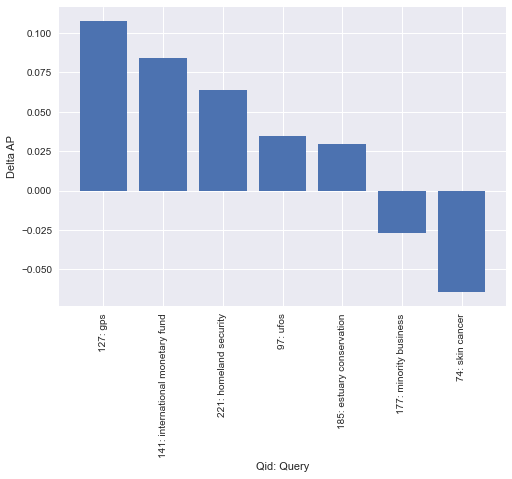

In [33]:
# compare with baseline PL2 per query

plot_delta(pl2_cusQE)

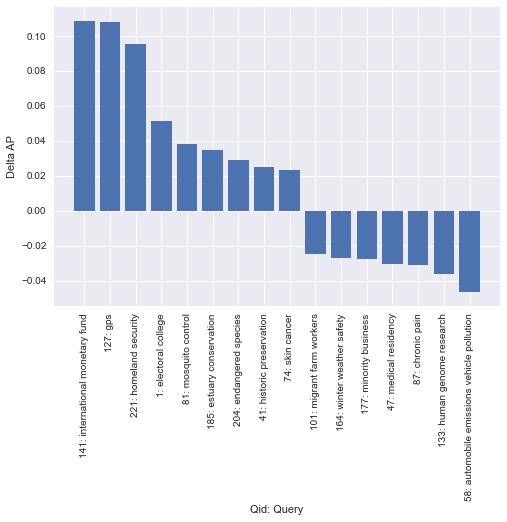

In [34]:
# compare the performance of BO1 and custom transformer per query

bo1_cusQE = pt.Experiment([pipe_QE, pipe_QE_cus],
                  dotgov_topicsqrels.get_topics(variant='td'),
                  dotgov_topicsqrels.get_qrels(variant='td'),
                  eval_metrics=['map'], round=4,
                  names=["BO1", "Word2Vec"], perquery=True)
plot_delta(bo1_cusQE)

# That's all Folks

**Submission Instructions:** Complete this notebook, and answer the related questions in the Exercise 2 Quiz Instance on Moodle. As part of the Quiz, you will be asked to upload your .ipynb notebook solution and answer various corresponding questions as per the exercise specification (use File... Download .ipynb).

Your responses to the Quiz along with your ipynb notebook solution must be submitted by **Wednesday 16th June 2021, 4:30pm**.